In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib # Để lưu/load preprocessor, model
import json   # Để lưu thông tin features

from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Cấu hình
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

# Định nghĩa đường dẫn
project_root = os.path.dirname(os.getcwd())
processed_data_folder = os.path.join(project_root, 'data', 'bts_processed')
models_folder = os.path.join(project_root, 'saved_models') # Thư mục lưu model và scaler

if not os.path.exists(models_folder):
    os.makedirs(models_folder)
    print('Đã tạo thư mục saved_models:', models_folder)

# Load dữ liệu đã làm giàu từ EDA (02)
input_filename_eda = 'flight_delay_2024_eda_enriched.csv'
eda_enriched_file_path = os.path.join(processed_data_folder, input_filename_eda)

df_model_input = None # Khởi tạo
if os.path.exists(eda_enriched_file_path):
    df_model_input = pd.read_csv(eda_enriched_file_path)
    print('Đã load dữ liệu từ:', eda_enriched_file_path)
    print('Shape của df_model_input:', df_model_input.shape)
    display(df_model_input.head())
else:
    print('LỖI: Không tìm thấy file {}.'.format(eda_enriched_file_path))
    print('Vui lòng chạy notebook EDA (Phần 2) và lưu file đúng cách trước.')

Đã load dữ liệu từ: C:\Users\hoiti\PycharmProjects\flight_delay_bts_project\data\bts_processed\flight_delay_2024_eda_enriched.csv
Shape của df_model_input: (5677, 18)


,airport,arr_cancelled,arr_diverted,arr_flights,carrier,carrier_ct,delay_rate,late_aircraft_ct,month,nas_ct,security_ct,weather_ct,year,carrier_ct_rate,weather_ct_rate,nas_ct_rate,security_ct_rate,late_aircraft_ct_rate
0,SGF,0.0,0.0,119.0,OH,5.50,0.134454,6.90,10,3.60,0.0,0.0,2024,0.046218,0.0,0.030252,0.0,0.057983
1,SHV,0.0,0.0,92.0,OH,4.56,0.130435,1.52,10,5.92,0.0,0.0,2024,0.049565,0.0,0.064348,0.0,0.016522
2,SRQ,7.0,0.0,31.0,OH,0.40,0.096774,2.57,10,0.03,0.0,0.0,2024,0.012903,0.0,0.000968,0.0,0.082903
3,STL,0.0,0.0,115.0,OH,6.87,0.130435,7.79,10,0.33,0.0,0.0,2024,0.059739,0.0,0.002870,0.0,0.067739
4,SYR,0.0,0.0,15.0,OH,1.42,0.266667,1.53,10,1.06,0.0,0.0,2024,0.094667,0.0,0.070667,0.0,0.102000


In [62]:
# Feature Selection & Target Definition

X = None # Dữ liệu features
y = None # Biến mục tiêu
selected_feature_names = [] # Danh sách tên các features được chọn
categorical_feature_names = [] # Tên các cột categorical
numeric_feature_names = []     # Tên các cột numeric

# Chỉ thực hiện nếu df_model_input đã được load và không rỗng
if 'df_model_input' in locals() and df_model_input is not None and not df_model_input.empty:
    target_col_name = 'delay_rate' # Tên biến mục tiêu

    # Các cột categorical tiềm năng
    potential_categorical_cols = ['month', 'carrier', 'airport']

    # Các cột numeric tiềm năng
    potential_numeric_cols = [
        'arr_flights', 'arr_cancelled', 'arr_diverted',
        'carrier_ct_rate', 'weather_ct_rate', 'nas_ct_rate',
        'security_ct_rate', 'late_aircraft_ct_rate'
    ]

    # Lọc ra những cột thực sự có trong DataFrame
    categorical_feature_names = [col for col in potential_categorical_cols if col in df_model_input.columns]
    numeric_feature_names = [col for col in potential_numeric_cols if col in df_model_input.columns]

    # Gộp lại và đảm bảo không trùng
    selected_feature_names = sorted(list(set(categorical_feature_names + numeric_feature_names)))

    # Đảm bảo biến mục tiêu không nằm trong danh sách features
    if target_col_name in selected_feature_names:
        selected_feature_names.remove(target_col_name)
        print("Cảnh báo: Biến mục tiêu '", target_col_name, "' đã bị loại khỏi features.")

    # Kiểm tra cuối cùng xem các feature đã chọn và target có trong DataFrame không
    all_selected_cols_exist = all(col in df_model_input.columns for col in selected_feature_names)
    target_exists = target_col_name in df_model_input.columns

    if all_selected_cols_exist and target_exists:
        X = df_model_input[selected_feature_names].copy() # Tạo X
        y = df_model_input[target_col_name].copy()       # Tạo y

        print("--- Features và Target đã được tạo ---")
        print("  Số features đã chọn:", len(selected_feature_names))
        print("  Features:", selected_feature_names)
        print("  Cột Categorical (sẽ xử lý):", categorical_feature_names)
        print("  Cột Numeric (sẽ xử lý):", numeric_feature_names)
        print("  Kích thước X:", X.shape, ", Kích thước y:", y.shape)
    else:
        if not all_selected_cols_exist:
            print("Lỗi nghiêm trọng: Một số selected features KHÔNG tìm thấy trong df_model_input.")
        if not target_exists:
            print("Lỗi nghiêm trọng: Cột target '", target_col_name, "' KHÔNG tìm thấy trong df_model_input.")
else:
    print("DataFrame 'df_model_input' rỗng hoặc chưa được load. Bỏ qua lựa chọn feature.")

--- Features và Target đã được tạo ---
  Số features đã chọn: 11
  Features: ['airport', 'arr_cancelled', 'arr_diverted', 'arr_flights', 'carrier', 'carrier_ct_rate', 'late_aircraft_ct_rate', 'month', 'nas_ct_rate', 'security_ct_rate', 'weather_ct_rate']
  Cột Categorical (sẽ xử lý): ['month', 'carrier', 'airport']
  Cột Numeric (sẽ xử lý): ['arr_flights', 'arr_cancelled', 'arr_diverted', 'carrier_ct_rate', 'weather_ct_rate', 'nas_ct_rate', 'security_ct_rate', 'late_aircraft_ct_rate']
  Kích thước X: (5677, 11) , Kích thước y: (5677,)


In [63]:
# Train-Test Split

X_train, X_test, y_train, y_test = (None, None, None, None) # Khởi tạo

# Chỉ thực hiện nếu X và y đã được tạo
if X is not None and y is not None:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.2,    # 20% dữ liệu cho test set
        random_state=42,  # Để kết quả chia lặp lại được
        shuffle=True      # Xáo trộn dữ liệu trước khi chia
    )
    print("--- Đã chia Train/Test ---")
    print("  X_train:", X_train.shape, ", y_train:", y_train.shape)
    print("  X_test:", X_test.shape, ",  y_test:", y_test.shape)
else:
    print("X hoặc y là None. Bỏ qua bước chia train-test.")

--- Đã chia Train/Test ---
  X_train: (4541, 11) , y_train: (4541,)
  X_test: (1136, 11) ,  y_test: (1136,)


In [64]:
# Feature Preprocessing (Encoding & Scaling)

X_train_processed = None # Dữ liệu train đã xử lý
X_test_processed = None  # Dữ liệu test đã xử lý
preprocessor = None      # Object để tiền xử lý (ColumnTransformer)
final_feature_names_after_transform = None # Tên cột sau khi OneHotEncoding

# Chỉ thực hiện nếu có dữ liệu train
if X_train is not None and X_test is not None:
    # Lấy lại tên cột categorical và numeric từ X_train để đảm bảo
    actual_cats_in_xtrain = [col for col in categorical_feature_names if col in X_train.columns]
    actual_nums_in_xtrain = [col for col in numeric_feature_names if col in X_train.columns]

    # Định nghĩa các bước biến đổi
    numeric_transformer_pipeline = StandardScaler()
    categorical_transformer_pipeline = OneHotEncoder(
        handle_unknown='ignore',
        sparse_output=False
    )

    # Tạo ColumnTransformer để áp dụng các biến đổi cho đúng cột
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer_pipeline, actual_nums_in_xtrain),
            ('cat', categorical_transformer_pipeline, actual_cats_in_xtrain)
        ],
        remainder='drop'
    )

    # Fit preprocessor trên X_train và biến đổi X_train
    print("Đang fit preprocessor trên X_train...")
    X_train_processed = preprocessor.fit_transform(X_train)

    # Biến đổi X_test (dùng preprocessor đã fit trên X_train)
    print("Đang transform X_test...")
    X_test_processed = preprocessor.transform(X_test)
    print("Tiền xử lý hoàn tất.")

    # Lấy tên các cột sau khi OneHotEncoding (để dễ hiểu hơn)
    try:
        ohe_feature_names = list(preprocessor.named_transformers_['cat']
                                 .get_feature_names_out(actual_cats_in_xtrain))
        final_feature_names_after_transform = actual_nums_in_xtrain + ohe_feature_names
        print("  Tổng số features sau xử lý:", len(final_feature_names_after_transform))
    except Exception as e:
        print("  Lưu ý: Không lấy được tên feature sau OHE:", e)
        print("        X_train_processed và X_test_processed sẽ là NumPy arrays không có tên cột.")
        final_feature_names_after_transform = None

    print("  Kích thước X_train_processed:", X_train_processed.shape)
    print("  Kích thước X_test_processed:", X_test_processed.shape)
else:
    print("Dữ liệu Train/Test không có. Bỏ qua tiền xử lý.")

Đang fit preprocessor trên X_train...
Đang transform X_test...
Tiền xử lý hoàn tất.
  Tổng số features sau xử lý: 385
  Kích thước X_train_processed: (4541, 385)
  Kích thước X_test_processed: (1136, 385)


In [65]:
# Save Preprocessor and Feature Info

# Chỉ lưu nếu preprocessor đã được tạo và có dữ liệu train
if preprocessor is not None and X_train is not None:
    # Đường dẫn và tên file để lưu preprocessor
    preprocessor_filename = 'flight_data_preprocessor.joblib'
    preprocessor_full_save_path = os.path.join(models_folder, preprocessor_filename) # models_folder từ cell đầu

    joblib.dump(preprocessor, preprocessor_full_save_path)
    print("Preprocessor đã được lưu vào:", preprocessor_full_save_path)

    # Lưu thông tin về các cột đã được dùng bởi preprocessor này
    feature_config_info = {
        'numeric_features_for_pipe': actual_nums_in_xtrain,
        'categorical_features_for_pipe': actual_cats_in_xtrain,
        'order_of_columns_in_X_train': list(X_train.columns), # Thứ tự cột của X_train khi fit preprocessor
        'order_of_processed_feature_names': final_feature_names_after_transform if final_feature_names_after_transform else 'Not available'
    }

    feature_config_filename = 'preprocessor_feature_config.json'
    feature_config_full_save_path = os.path.join(models_folder, feature_config_filename)

    try:
        with open(feature_config_full_save_path, 'w') as f_json: # Đổi tên biến file
            json.dump(feature_config_info, f_json, indent=4)
        print("Thông tin cấu hình feature của Preprocessor đã lưu vào:", feature_config_full_save_path)
    except Exception as e:
        print("Lỗi khi lưu feature_config.json:", e)
else:
    # In ra lý do không lưu
    if preprocessor is None: print("Preprocessor chưa được tạo. Bỏ qua việc lưu.")
    if X_train is None: print("X_train không có. Không thể lưu thông tin feature.")

Preprocessor đã được lưu vào: C:\Users\hoiti\PycharmProjects\flight_delay_bts_project\saved_models\flight_data_preprocessor.joblib
Thông tin cấu hình feature của Preprocessor đã lưu vào: C:\Users\hoiti\PycharmProjects\flight_delay_bts_project\saved_models\preprocessor_feature_config.json


In [66]:
# Save Preprocessor and Feature Info

# Chỉ lưu nếu preprocessor đã được tạo và có dữ liệu train
if preprocessor is not None and X_train is not None:
    # Đường dẫn và tên file để lưu preprocessor
    preprocessor_filename = 'flight_data_preprocessor.joblib'
    preprocessor_full_save_path = os.path.join(models_folder, preprocessor_filename) # models_folder từ cell đầu

    joblib.dump(preprocessor, preprocessor_full_save_path)
    print("Preprocessor đã được lưu vào:", preprocessor_full_save_path)

    # Lưu thông tin về các cột đã được dùng bởi preprocessor
    feature_config_info = {
        'numeric_features_for_pipe': actual_nums_in_xtrain,
        'categorical_features_for_pipe': actual_cats_in_xtrain,
        'order_of_columns_in_X_train': list(X_train.columns), # Thứ tự cột của X_train khi fit preprocessor
        'order_of_processed_feature_names': final_feature_names_after_transform if final_feature_names_after_transform else 'Not available'
    }

    feature_config_filename = 'preprocessor_feature_config.json'
    feature_config_full_save_path = os.path.join(models_folder, feature_config_filename)

    try:
        with open(feature_config_full_save_path, 'w') as f_json: # Đổi tên biến file
            json.dump(feature_config_info, f_json, indent=4)
        print("Thông tin cấu hình feature của Preprocessor đã lưu vào:", feature_config_full_save_path)
    except Exception as e:
        print("Lỗi khi lưu feature_config.json:", e)
else:
    # In ra lý do không lưu
    if preprocessor is None: print("Preprocessor chưa được tạo. Bỏ qua việc lưu.")
    if X_train is None: print("X_train không có. Không thể lưu thông tin feature.")

Preprocessor đã được lưu vào: C:\Users\hoiti\PycharmProjects\flight_delay_bts_project\saved_models\flight_data_preprocessor.joblib
Thông tin cấu hình feature của Preprocessor đã lưu vào: C:\Users\hoiti\PycharmProjects\flight_delay_bts_project\saved_models\preprocessor_feature_config.json


In [67]:
# Imports for Modeling

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from mlflow.models.signature import infer_signature

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import mlflow
import mlflow.sklearn
import numpy as np
import os
import joblib

# --- Kiểm tra nhanh các biến cần thiết ---
required_vars = ['X_train_processed', 'X_test_processed', 'y_train', 'y_test',
                 'preprocessor', 'models_folder', 'project_root',
                 'categorical_feature_names', 'numeric_feature_names'] # Các biến từ cell trước

all_vars_exist = True
for var_name in required_vars:
    if var_name not in locals() or locals()[var_name] is None:
        print("LỖI: Biến '", var_name, "' chưa tồn tại hoặc là None. Hãy chạy lại các cell trước!")
        all_vars_exist = False
        break

if all_vars_exist:
    print("Dữ liệu và các đối tượng cần thiết đã sẵn sàng cho modeling.")
    print("X_train_processed shape:", X_train_processed.shape)

# --- Đặt tên MLflow experiment ---
exp_name = os.path.basename(project_root) + "_Training_Runs"
mlflow.set_experiment(exp_name)
print("MLflow Experiment:", exp_name)

Dữ liệu và các đối tượng cần thiết đã sẵn sàng cho modeling.
X_train_processed shape: (4541, 385)
MLflow Experiment: flight_delay_bts_project_Training_Runs


In [68]:
# Hàm tiện ích để Huấn luyện, Đánh giá và Log Model
def train_evaluate_log_model(model, model_name_str, X_train, y_train, X_test, y_test,
                             feature_names_list=None, preprocessor_to_log=None,
                             preprocessor_config_path=None):
    # GIẢ ĐỊNH `visualizations_folder` là biến toàn cục và đã tồn tại

    run_display_name = model_name_str + "_run"
    print("\nBắt đầu Run cho:", model_name_str)

    with mlflow.start_run(run_name=run_display_name) as run:
        run_id = run.info.run_id
        print("  MLflow Run ID:", run_id)

        # Huấn luyện model
        model.fit(X_train, y_train)
        print("  Huấn luyện xong.")

        # Dự đoán trên tập test
        y_pred = model.predict(X_test)

        # Đánh giá model
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)

        print("  Đánh giá trên tập Test:")
        print("    MAE :", mae); mlflow.log_metric("mae", mae)
        print("    MSE :", mse); mlflow.log_metric("mse", mse)
        print("    RMSE:", rmse); mlflow.log_metric("rmse", rmse)
        print("    R2  :", r2); mlflow.log_metric("r2_score", r2)

        # Log params
        try:
            mlflow.log_params(model.get_params())
        except AttributeError:
            pass # Bỏ qua nếu không có get_params

        # Log model
        mlflow.sklearn.log_model(model, artifact_path=model_name_str + "_model")
        print("  Model đã được log vào MLflow với path:", model_name_str + "_model")

        if preprocessor_to_log is not None:
            mlflow.sklearn.log_model(preprocessor_to_log, artifact_path="preprocessor")
            print("  Preprocessor đã được log.")
            if preprocessor_config_path and os.path.exists(preprocessor_config_path):
                mlflow.log_artifact(preprocessor_config_path, artifact_path="preprocessor_config")
                print("  File cấu hình preprocessor đã được log.")

        if feature_names_list:
            features_path = "selected_features.txt"
            with open(features_path, "w") as f:
                for feature in feature_names_list:
                    f.write(str(feature) + "\n")
            mlflow.log_artifact(features_path, artifact_path="feature_info")
            print("  Danh sách features đã được log.")
            os.remove(features_path)

        # (Tùy chọn) Vẽ đồ thị và log: Actual vs Predicted
        plt.figure(figsize=(8,5))
        plt.scatter(y_test, y_pred, alpha=0.3, edgecolors='w', linewidth=0.5)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--k', lw=2)
        plt.xlabel("Giá trị Thực tế (y_test)")
        plt.ylabel("Giá trị Dự đoán (y_pred)")
        plt.title("Thực tế vs. Dự đoán cho " + model_name_str)

        # === VÀI DÒNG THÊM VÀO ĐÂY ===
        plot_filename_only = model_name_str + "_actual_vs_predicted.png"
        # Sử dụng trực tiếp biến toàn cục `visualizations_folder`
        full_plot_path = os.path.join(visualizations_folder, plot_filename_only)
        plt.savefig(full_plot_path) # Lưu vào đường dẫn mới


        mlflow.log_artifact(full_plot_path, artifact_path="evaluation_plots") # Log file từ đường dẫn mới
        print(f"  Đồ thị Actual vs. Predicted đã được lưu vào '{full_plot_path}' và log vào MLflow.")
        plt.close()

        print("--- Kết thúc Run cho:", model_name_str, "---")
        return model

# Đường dẫn đến file config preprocessor đã lưu ở cell trước
preprocessor_config_file_path = os.path.join(models_folder, 'preprocessor_feature_config.json')


Bắt đầu Run cho: LinearRegression
  MLflow Run ID: 6203428bd5a54e4f9d06426b9c334b21
  Huấn luyện xong.
  Đánh giá trên tập Test:
    MAE : 7.965947246244615e-05
    MSE : 2.0114938449678666e-08
    RMSE: 0.00014182714285241265
    R2  : 0.9999979847370459


2025/05/31 16:55:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


  Model đã được log vào MLflow với path: LinearRegression_model


NameError: name 'visualizations_folder' is not defined

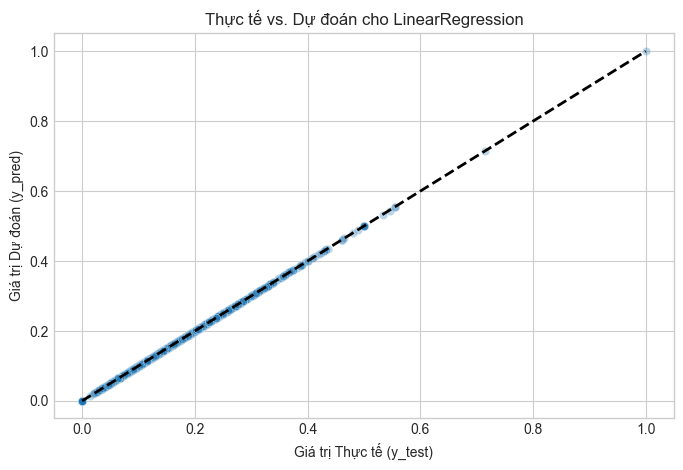

In [69]:
# Training different regression models

trained_models_collection = {}

if all_vars_exist:
    # Model 1: Linear Regression
    lr = LinearRegression()
    trained_models_collection["LinearRegression"] = train_evaluate_log_model(
        lr, "LinearRegression",
        X_train_processed, y_train, X_test_processed, y_test
    )

    # Model 2: Decision Tree Regressor
    dt = DecisionTreeRegressor(random_state=42, max_depth=10) # Giữ max_depth
    trained_models_collection["DecisionTree"] = train_evaluate_log_model(
        dt, "DecisionTree",
        X_train_processed, y_train, X_test_processed, y_test
    )

    # Model 3: Random Forest Regressor
    rf = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1, max_depth=10)
    trained_models_collection["RandomForest"] = train_evaluate_log_model(
        rf, "RandomForest",
        X_train_processed, y_train, X_test_processed, y_test
    )

    # Model 4: Gradient Boosting Regressor
    gbr = GradientBoostingRegressor(n_estimators=50, learning_rate=0.1, max_depth=5, random_state=42)
    trained_models_collection["GradientBoosting"] = train_evaluate_log_model(
        gbr, "GradientBoosting",
        X_train_processed, y_train, X_test_processed, y_test
    )

    # Model 5: Ridge
    ridge = Ridge(alpha=1.0, random_state=42)
    trained_models_collection["Ridge"] = train_evaluate_log_model(ridge, "Ridge", X_train_processed, y_train, X_test_processed, y_test)

    print("\nHoàn thành huấn luyện các model. Kiểm tra MLflow UI")
else:
    print("Không thể huấn luyện model do thiếu dữ liệu đầu vào.")

In [40]:
# Select and Save the Best Model
chosen_best_model_name = "GradientBoosting"

best_model_to_save = trained_models_collection.get(chosen_best_model_name)

if best_model_to_save is not None:
    # 1. Lưu model tốt nhất
    final_model_filename = "final_best_flight_delay_model.joblib"
    final_model_path = os.path.join(models_folder, final_model_filename)
    joblib.dump(best_model_to_save, final_model_path)
    print("Model tốt nhất ('", chosen_best_model_name, "') đã lưu vào:", final_model_path)

    # 2. Lưu preprocessor
    if 'preprocessor' in locals() and preprocessor is not None:
        preprocessor_filename_to_save = "data_preprocessor_for_best_model.joblib"
        preprocessor_path_to_save = os.path.join(models_folder, preprocessor_filename_to_save)
        joblib.dump(preprocessor, preprocessor_path_to_save)
        print("Preprocessor đi kèm model tốt nhất đã lưu vào:", preprocessor_path_to_save)

        # Lưu luôn file cấu hình feature của preprocessor nếu có
        preprocessor_cfg_filename = "preprocessor_feature_config_best_model.json"
        preprocessor_cfg_path = os.path.join(models_folder, preprocessor_cfg_filename)
        if 'feature_config_info' in locals() and feature_config_info is not None:
             with open(preprocessor_cfg_path, 'w') as f_cfg:
                json.dump(feature_config_info, f_cfg, indent=4) # feature_config_info tạo ở cell lưu preprocessor trước
             print("Cấu hình feature của preprocessor đã lưu:", preprocessor_cfg_path)
        else:
            feature_config_info_recheck = {
                'numeric_features_for_pipe': numeric_feature_names if 'numeric_feature_names' in locals() else [],
                'categorical_features_for_pipe': categorical_feature_names if 'categorical_feature_names' in locals() else [],
                'order_of_columns_in_X_train': list(X_train.columns) if 'X_train' in locals() and X_train is not None else [],
                'order_of_processed_feature_names': final_feature_names_after_transform if 'final_feature_names_after_transform' in locals() else 'Not available'
            }
            with open(preprocessor_cfg_path, 'w') as f_cfg:
                json.dump(feature_config_info_recheck, f_cfg, indent=4)
            print("Cấu hình feature của preprocessor (lấy lại) đã lưu:", preprocessor_cfg_path)

        # 3. Log model tốt nhất, preprocessor và config lên 1 run MLflow đặc biệt
        with mlflow.start_run(run_name="BestModel_" + chosen_best_model_name) as best_run:
            print("\nLogging Best Model artifacts to MLflow run ID:", best_run.info.run_id)
            mlflow.sklearn.log_model(best_model_to_save, "best_model_final")
            mlflow.sklearn.log_model(preprocessor, "preprocessor_final")
            mlflow.log_artifact(preprocessor_cfg_path, "preprocessor_config_final")
            mlflow.set_tag("best_model", "True")
            print("Đã log model tốt nhất, preprocessor và config lên 1 run MLflow riêng.")

    else:
        print("Không tìm thấy preprocessor để lưu.")
else:
    print("Model '", chosen_best_model_name, "' không có trong trained_models_collection.")

Model tốt nhất (' GradientBoosting ') đã lưu vào: C:\Users\hoiti\PycharmProjects\flight_delay_bts_project\saved_models\final_best_flight_delay_model.joblib
Preprocessor đi kèm model tốt nhất đã lưu vào: C:\Users\hoiti\PycharmProjects\flight_delay_bts_project\saved_models\data_preprocessor_for_best_model.joblib
Cấu hình feature của preprocessor đã lưu: C:\Users\hoiti\PycharmProjects\flight_delay_bts_project\saved_models\preprocessor_feature_config_best_model.json

Logging Best Model artifacts to MLflow run ID: 037961fedfec4bc5bf6f844f984782d0


2025/05/31 10:07:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/05/31 10:07:04 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2025/05/31 10:07:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Đã log model tốt nhất, preprocessor và config lên 1 run MLflow riêng.
